### imports

In [24]:
import cv2
import numpy as np
from PIL import Image
from glob import glob
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### getting data

Dataset used:

https://www.kaggle.com/datasets/die9origephit/children-vs-adults-images

In [ ]:
!unzip /content/child_vs_adult.zip

In [4]:
#Transforms
train_transforms=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

test_transforms=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [5]:
train_data_path = 'train' 
test_data_path = 'test'

def flatten(l):
    return [item for sublist in l for item in sublist]

train_image_paths = [] #to store image paths in list
classes = [] #to store class values


for data_path in glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))


train_image_paths, valid_image_paths = train_test_split(train_image_paths, test_size=0.25, random_state=42)

test_image_paths = []
for data_path in glob(test_data_path + '/*'):
    test_image_paths.append(glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Train size: 510
Valid size: 170
Test size: 120


In [6]:
print(classes)

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

['adults', 'children']


#### creating dataset and dataloaders

In [7]:
class MyCustomDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath)
        # image = cv2.imread(image_filepath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label


train_dataset = MyCustomDataset(train_image_paths,train_transforms)
valid_dataset = MyCustomDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = MyCustomDataset(test_image_paths,test_transforms)

In [8]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 256, 256])
The label for 50th image in train dataset:  1


In [9]:
train_loader = DataLoader( train_dataset, batch_size=64, shuffle=True )

valid_loader = DataLoader( valid_dataset, batch_size=64, shuffle=True )

test_loader = DataLoader( test_dataset, batch_size=64, shuffle=False )

dataloaders = {'train':train_loader, 'val':valid_loader}

### neural network

In [17]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [18]:
#Optmizer and loss function
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

#### define the train function and loop

In [19]:
def train_model(model,criterion,optimizer,dataloaders,epochs,check_every=None,earlyStopping=False):

  print("training model")
  optimizer.zero_grad()

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  phases = dataloaders.keys()
  valExists = True if "val" in phases else False
  avg_loss = {phase:0 for phase in phases}
  avg_losses = {phase:[] for phase in phases}

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    batchLoss = {phase:[] for phase in phases}

     # Each epoch has a training and validation phase
    for phase in phases:
      if phase == "train":  model.train()  # Set model to training mode
      else: model.eval()   # Set model to evaluate mode
        
      for i, (inputBatch,labelBatch) in enumerate(tqdm(dataloaders[phase], leave=False)):

          inputBatch = inputBatch.to(device).float()
          labelBatch = labelBatch.to(device)
          
          # forward
          with torch.set_grad_enabled(not phase=="val"):
            outputBatch = model(inputBatch)
          loss = criterion(outputBatch, labelBatch)
          batchLoss[phase].append(loss.item())

          # backward + optimize only if in training phase
          if phase == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


    for phase in phases : avg_loss[phase] = np.mean(batchLoss[phase])
        
    phase = "val" if valExists else "train"
    if epoch > 0:
      if avg_loss[phase] < min(avg_losses[phase]):
        best_params = deepcopy(model.state_dict())
        best_epoch, best_loss = epoch, avg_loss[phase]
    else:
      best_params = deepcopy(model.state_dict())
      best_epoch, best_loss = epoch, avg_loss[phase]
      movAvg_old = avg_loss[phase]

    for phase in phases : avg_losses[phase].append(avg_loss[phase])  

    # print statistics
    if epoch % check_every == check_every - 1:
      print("epoch: %d" % (epoch + 1), end="  | ")
      for phase in phases:
        print("%s loss: %.3f" % (phase, avg_loss[phase]), end=", ")
      if check_every > 1:
        print(" | ", end='')
        for phase in phases:        
          print("avg %s loss: %.3f" % (phase, np.mean(avg_losses[phase][epoch+1-check_every:epoch+1])), end=", ")
      if valExists:
        movAvg_new = np.mean(avg_losses["val"][epoch+1-check_every:epoch+1])

      if (valExists) and earlyStopping:
        if movAvg_old < movAvg_new:   break
        else:   movAvg_old = movAvg_new



  end_params = deepcopy(model.state_dict())
  print('Finished Training')
  for phase in phases:  plt.plot(avg_losses[phase], label=phase+" loss")
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params, end_params

training model


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 1  | train loss: 3.988, val loss: 8.295, 

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 2  | train loss: 0.455, val loss: 1.105, 

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 3  | train loss: 0.142, val loss: 0.393, 

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 4  | train loss: 0.097, val loss: 1.427, 

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 5  | train loss: 0.053, val loss: 0.342, Finished Training


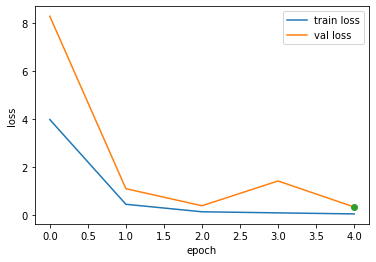

In [20]:
best_params, end_params = train_model(model, criterion, optimizer, dataloaders, 5)

In [21]:
model.load_state_dict(best_params)

<All keys matched successfully>

#### evaluate

In [27]:
def evaluate(net, loader):

  net.eval()
  output_pred = []
  output_true = []

  for i, (inputBatch,labelBatch) in enumerate(tqdm(loader)):
      inputBatch = inputBatch.to(device).float()
      labelBatch = labelBatch.to(device)

      # forward
      with torch.no_grad():
        outputBatch = net(inputBatch)
      for output, label in zip(outputBatch,labelBatch):
        output_true.append(label.cpu().numpy())
        val, indx = torch.max(output,0)
        output_pred.append(indx.cpu().numpy())

  print(classification_report(output_true, output_pred, target_names=classes, digits=4))         

In [28]:
evaluate(model, test_loader)

  0%|          | 0/2 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      adults     0.8772    0.8333    0.8547        60
    children     0.8413    0.8833    0.8618        60

    accuracy                         0.8583       120
   macro avg     0.8592    0.8583    0.8582       120
weighted avg     0.8592    0.8583    0.8582       120

